<a href="https://colab.research.google.com/github/ssnyu/RL-Informed-Oil-Trader/blob/main/RL_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install gym-anytrading gymnasium stable-baselines3 quantstats yfinance finta yahoofinance

In [ ]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import A2C, PPO
from gym_anytrading.envs import Actions, StocksEnv
from finta import TA
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv
import quantstats as qs
import torch

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


## Using LSTM to make predictions

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

# Load the data
data = pd.read_csv("/content/US_Crude_data_v1.csv")

# Extract features and target
features = data[['Crude Oil Production', 'Dry Natural Gas Production', 'Coal Production',
                 'Total Energy Production (qBtu)', 'Liquid Fuels Consumption',
                 'Natural Gas Consumption', 'Coal Consumption', 'Electricity Consumption',
                 'Renewables Consumption', 'Total Energy Consumption (qBtu)',
                 'Natural Gas ($/mBtu) ', 'Coal ($/mBtu)',
                 'Real Gross Domestic Product (Trillions)',
                 'RGDP Percent change YOY (%)', 'GDP Implicit Price Deflator',
                 'GDP IPD Percent change YOY (%)', 'Real Disposable Personal Income',
                 'RDPI Percent change YOY (%)', 'Manufacturing Production Index',
                 'MPI Percent change YOY (%)']]

feats = ['Crude Oil Production', 'Dry Natural Gas Production', 'Coal Production',
                 'Total Energy Production (qBtu)', 'Liquid Fuels Consumption',
                 'Natural Gas Consumption', 'Coal Consumption', 'Electricity Consumption',
                 'Renewables Consumption', 'Total Energy Consumption (qBtu)',
                 'Natural Gas ($/mBtu) ', 'Coal ($/mBtu)',
                 'Real Gross Domestic Product (Trillions)',
                 'RGDP Percent change YOY (%)', 'GDP Implicit Price Deflator',
                 'GDP IPD Percent change YOY (%)', 'Real Disposable Personal Income',
                 'RDPI Percent change YOY (%)', 'Manufacturing Production Index',
                 'MPI Percent change YOY (%)']
target = data['Crude Oil ($/barrel)']

# Data preprocessing
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Reshape for LSTM input
scaled_features = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

# Load the saved model
loaded_model = load_model("/content/crude_oil_price_prediction_model.h5")

# Make predictions
predictions = loaded_model.predict(scaled_features)
predictions = scaler.inverse_transform(predictions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14/14 [==============================] - 1s 3ms/step


In [ ]:
data["Close"] = data['Crude Oil ($/barrel)']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data["pred"] = np.array(predictions.flatten())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data['pred'] = data['pred'].shift(-5)
data['pred'].fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


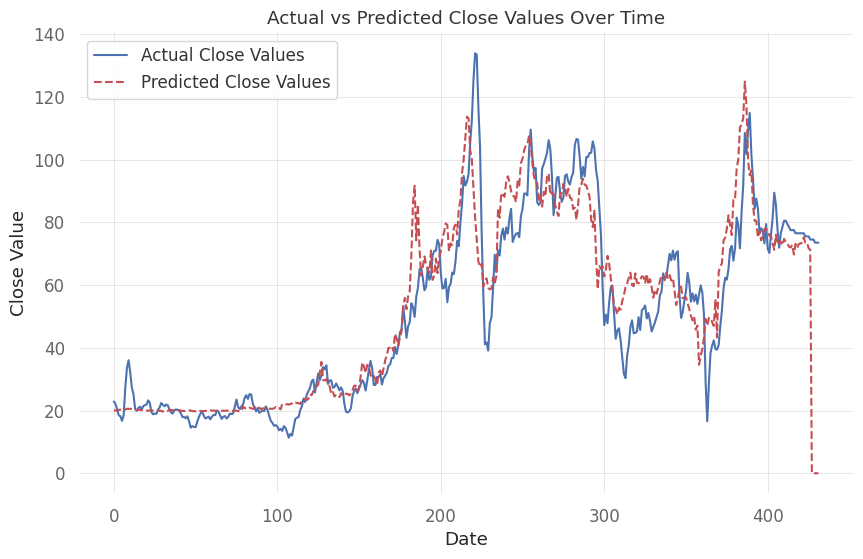

In [ ]:
import matplotlib.pyplot as plt

# Assuming df contains actual close values and result_df contains predicted values

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual close values
plt.plot(data.index, data["Close"], linestyle='-', color='b', label='Actual Close Values')

# Plot predicted values
plt.plot(data.index, data['pred'], linestyle='--', color='r', label='Predicted Close Values')

plt.title('Actual vs Predicted Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.legend()
plt.show()


Initializing environment

In [ ]:
df = data
del data

In [ ]:
df

,Dates,Crude Oil Production,Dry Natural Gas Production,Coal Production,Total Energy Production (qBtu),Liquid Fuels Consumption,Natural Gas Consumption,Coal Consumption,Electricity Consumption,Renewables Consumption,...,Real Gross Domestic Product (Trillions),RGDP Percent change YOY (%),GDP Implicit Price Deflator,GDP IPD Percent change YOY (%),Real Disposable Personal Income,RDPI Percent change YOY (%),Manufacturing Production Index,MPI Percent change YOY (%),Close,pred
0,1/1/1990,7.55,52.17,91,5.32,16.96,0.00,78,8.11,0.00,...,10.047,2.8,58.4,3.6,7187,2.2,58.0,-2.1,22.86,20.069828
1,2/1/1990,7.50,51.45,82,5.06,17.18,0.00,69,7.97,0.00,...,10.047,2.8,58.4,3.6,7203,2.1,58.8,0.3,22.11,20.014166
2,3/1/1990,7.43,49.30,92,5.24,17.09,0.00,72,7.25,0.00,...,10.047,2.8,58.4,3.6,7206,1.7,59.1,0.9,20.39,19.886257
3,4/1/1990,7.41,48.29,83,4.97,16.78,0.00,68,7.18,0.00,...,10.084,2.4,59.1,3.7,7253,2.9,58.9,0.4,18.43,20.224874
4,5/1/1990,7.33,47.26,87,5.03,16.92,0.00,70,7.04,0.00,...,10.084,2.4,59.1,3.7,7246,3.3,59.0,1.5,18.20,20.268925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,8/1/2025,13.46,106.04,40,6.70,20.88,86.16,41,13.32,0.80,...,23.026,1.4,128.4,2.2,17835,2.9,102.0,1.4,74.50,0.000000
428,9/1/2025,13.40,105.89,36,6.58,20.21,79.53,30,12.01,0.75,...,23.054,1.4,128.6,2.2,17835,2.9,102.1,1.5,74.50,0.000000
429,10/1/2025,13.45,105.96,37,6.61,20.54,78.97,24,10.39,0.77,...,23.083,1.4,128.9,2.2,17926,2.7,102.3,1.4,73.50,0.000000
430,11/1/2025,13.56,106.21,35,6.59,20.43,92.53,24,10.29,0.77,...,23.112,1.4,129.1,2.1,17926,2.7,102.5,1.5,73.50,0.000000


In [ ]:
window_size = 5
start_index = window_size
test_period = 100

end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)

observation_space: Box(-10000000000.0, 10000000000.0, (5, 2), float32)


Getting technical indicators

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['pred']].to_numpy()[start:end]
    return prices, signal_features

In [ ]:
test_start = end_index - test_period
test_end = end_index

In [ ]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

env = MyCustomEnv(df, window_size=window_size, frame_bound=(test_start,test_end))

In [ ]:
env.action_space

Discrete(2)

In [ ]:
env.reset()
model = A2C('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=50000)

In [ ]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset()

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 77, <Actions.Buy: 1>: 22}
info: {'total_reward': 45.23000000000002, 'total_profit': 1.6552010732799098, 'position': <Positions.Short: 0>}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


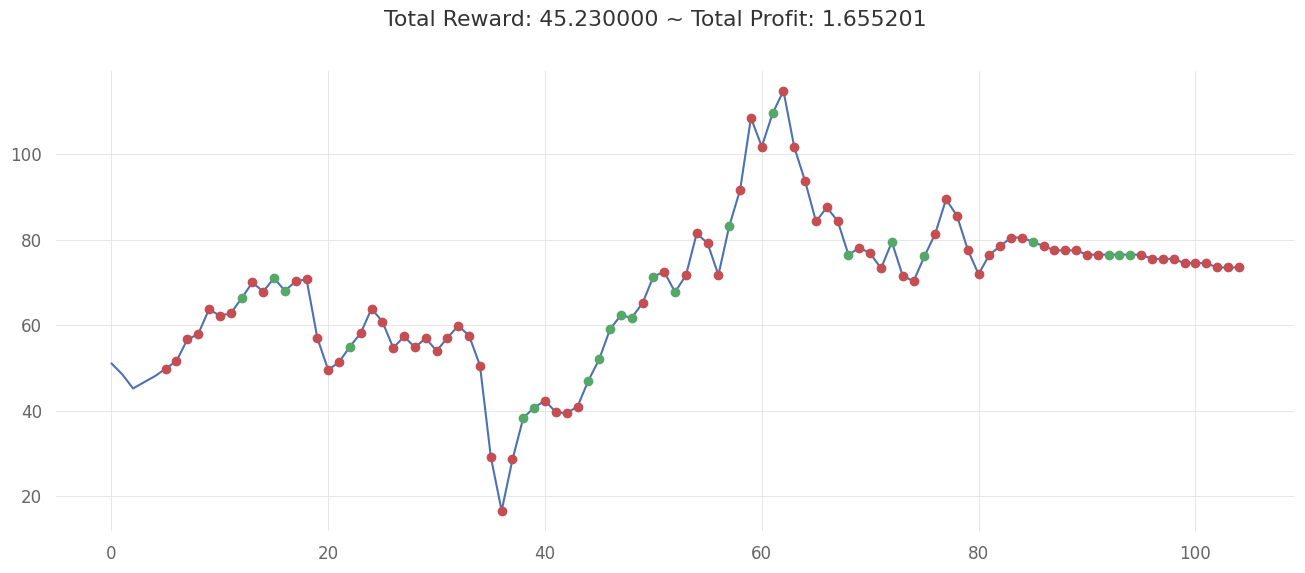

In [ ]:
plt.figure(figsize=(16, 6))
env.unwrapped.render_all()
plt.show()

In [ ]:
qs.extend_pandas()

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[test_start+1:test_end])
returns = net_worth.pct_change().iloc[1:]

[Performance Metrics]

                           Strategy
-------------------------  ----------
Start Period               2017-11-01
End Period                 2025-12-01
Risk-Free Rate             0.0%
Time in Market             15.0%

Cumulative Return          65.52%
CAGR﹪                     4.4%

Sharpe                     2.24
Prob. Sharpe Ratio         99.12%
Smart Sharpe               2.2
Sortino                    7.75
Smart Sortino              7.59
Sortino/√2                 5.48
Smart Sortino/√2           5.37
Omega                      4.2

Max Drawdown               -11.25%
Longest DD Days            946
Volatility (ann.)          66.18%
Calmar                     0.39
Skew                       6.68
Kurtosis                   58.56

Expected Daily %           0.52%
Expected Monthly %         0.52%
Expected Yearly %          5.76%
Kelly Criterion            54.43%
Risk of Ruin               0.0%
Daily Value-at-Risk        -6.27%
Expected Shortfall (cVaR)  -6.27%

Max Co

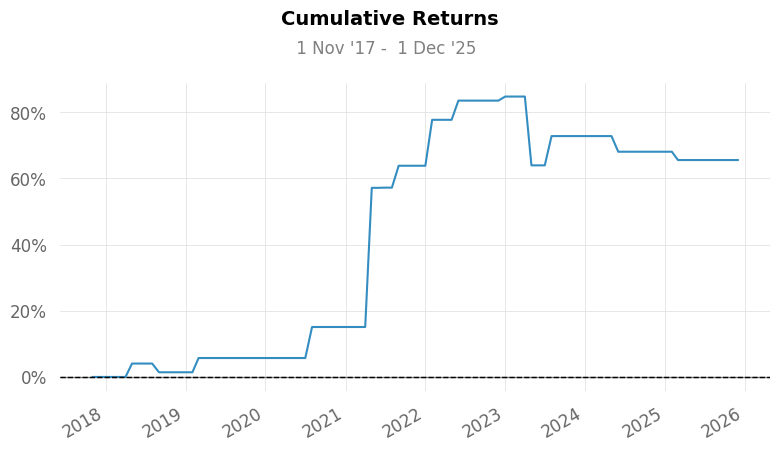

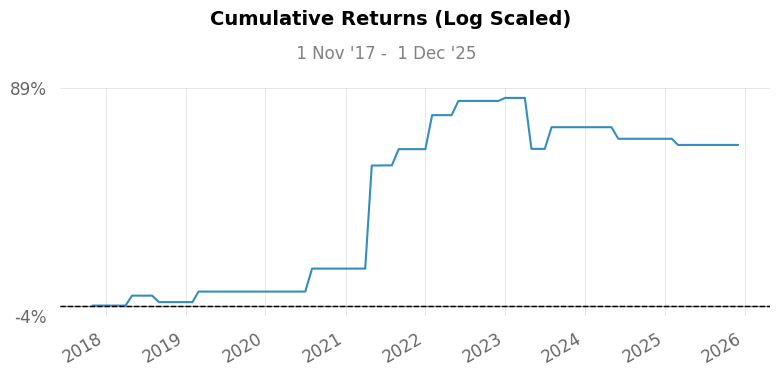

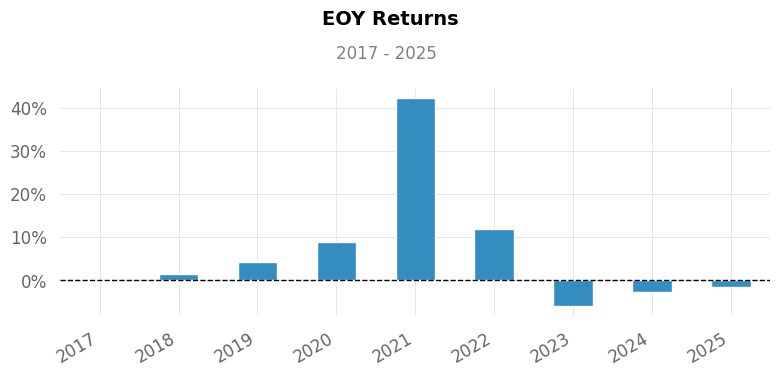

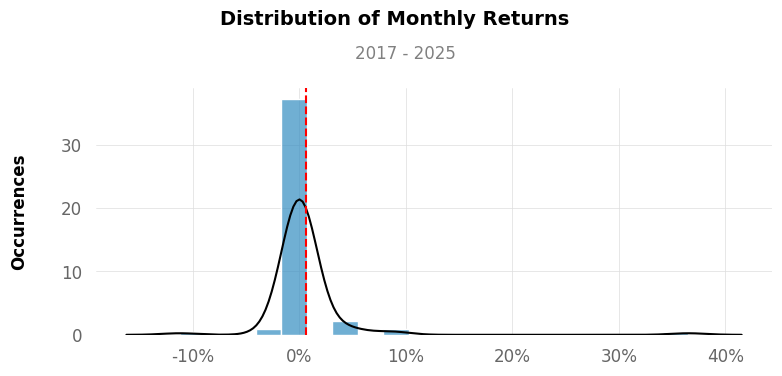

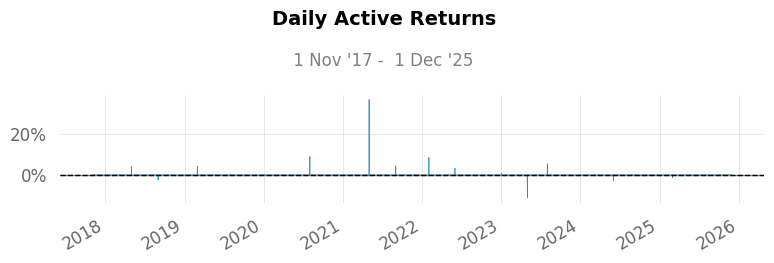

IndexError: index 0 is out of bounds for axis 0 with size 0

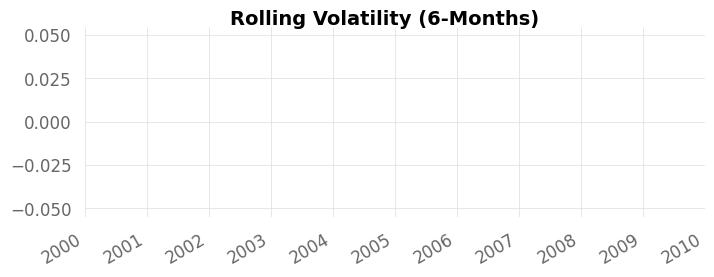

In [ ]:
import pandas as pd

# Assuming df is your DataFrame with "Dates" as the index
df['Dates'] = pd.to_datetime(df['Dates'])  # Convert "Dates" to datetime if not already
df.set_index('Dates', inplace=True)  # Set "Dates" as the index

net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[-len(env.unwrapped.history['total_profit']):])
returns = net_worth.pct_change().iloc[1:]

# Check if returns is not empty
if not returns.empty:
    qs.extend_pandas()
    qs.reports.full(returns)
    qs.reports.html(returns, output='SB3_a2c_quantstats.html')
else:
    print("Error: returns DataFrame is empty.")